# Project : Statistical Methods for High Dimensional Data
# News classification
###  Anna Badalyan, Andrii Kliachkin, Gianmarco Lattaruolo, Francesco Sartori

In this project we will test several models seen during the lectures to address a text classification problem. 
Specifically we will work on a dataset of 100k news titles classified in 8 different classes. First of all we install all the needed packages.

In [ ]:
install.packages('quanteda')
install.packages('quanteda.textplots')
install.packages('glmnet')
install.packages('doMC')
install.packages('sparseSVM')
install.packages('doParallel')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘ISOcodes’, ‘fastmatch’, ‘Rcpp’, ‘RcppParallel’, ‘SnowballC’, ‘stopwords’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘coda’, ‘extrafontdb’, ‘Rttf2pt1’, ‘statnet.common’, ‘extrafont’, ‘ggrepel’, ‘sna’, ‘igraph’, ‘network’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Dataset description

Here we load the libraries and download the .csv file from the link.

In [ ]:
library('doParallel')
library('quanteda')
library('quanteda.textplots')
library('glmnet')
library('doMC')
library('sparseSVM')

id <- "1t_bpJX7PC0dqZ5pEmaxM8wmDJteYmOXB" # google file ID
news <- read.csv(sprintf("https://docs.google.com/uc?id=%s&export=download", id), row.names=NULL, sep = ';')
nrow(news)

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel

Package version: 3.2.4
Unicode version: 10.0
ICU version: 60.2

Parallel computing: 2 of 2 threads used.

See https://quanteda.io for tutorials and examples.

Loading required package: Matrix

Loaded glmnet 4.1-6



[1] 108774

The csv file contains 108774 articles for 8 different news topics, published over the first half of August 2020. The topics are:
* BUSINESS 
* ENTERTAINMENT 
* HEALTH
* NATION
* SCIENCE
* SPORTS
* TECHNOLOGY
* WORLD

All topics have 15k articles except for SCIENCE which is 3774. Those articles are published by thousands of different news websites. Since the classes are quite balnced we do not need resample methods. Moreover the size of the dataset is enough for carry out our statistical analysis and we will not use boostrap methods.

## Preprocessing

We implemented the following preprocessing pipeline. 
First of all we create a training set and a test set. The train is four times the size of the test.

In [ ]:
set.seed(123)
size <- floor(0.8 * nrow(news))
mask <- sample(seq_len(nrow(news)), size=size)
data_train <- news[mask, ]
data_test <- news[-mask, ]

With this function we clean all the titles contained in the data set, making one foundamental step of our preprocessing. 

We remove punctuation, symbols, numbers, site urls, separators and separator characters. Then we lower the case of the letters, remove the stop words and stemmatize the words.
Finally we build a document frequency matrix, trim the words which appear less than ```docfreq = 8 ``` times and build in this way our vocabulary. After this with the same function we can build the frequency matrix of the test set using only the words in the vocabulary already built.

In [ ]:
prepare_dfm <- function(src, fit=TRUE, words_to_include=NULL, docfreq = 8){
  # does the preprocessing steps, returns a dfm
  # fit=TRUE trims based on frequency
  # fit=FALSE makes the features=words_to_include
  tokens <- quanteda::tokens(src,remove_punct = TRUE,
            remove_symbols = TRUE,
            remove_numbers = TRUE,
            remove_url = TRUE,)
  dfm <- quanteda::dfm(tokens, tolower = TRUE)
  dfm <- quanteda::dfm_remove(dfm,stopwords('english'))
  dfm <- quanteda::dfm_wordstem(dfm)
  if(fit) {
    dfm <- quanteda::dfm_trim(dfm, min_docfreq = docfreq)
  } else {
    dfm <- quanteda::dfm_match(dfm, words_to_include)
  }
  return(dfm)
}

As said before, the ``` prepare_dfm``` function is applyed only the training set and then, for the test set it retains only the words already present in the vocabulary built from the training.

In [ ]:
dfm_train <- prepare_dfm(data_train$title)
dfm_test <- prepare_dfm(data_test$title, fit=FALSE, words_to_include = featnames(dfm_train))

Now we compute the text frequency - inverse document frequency matrix of our data sets.

In [ ]:
# tf-idf, calculated on train
# weight the matrices with tf
x_train <- quanteda::dfm_weight(dfm_train, scheme='prop')
x_test <- quanteda::dfm_weight(dfm_test, scheme='prop')
# calculate idfs on train
idfs <- docfreq(dfm_train, scheme='inverse')
# weight by idfs
x_train <- quanteda::dfm_weight(x_train, weights=idfs, force=TRUE)
x_test <- quanteda::dfm_weight(x_test, weights=idfs, force=TRUE)

x_train <- as(x_train,"sparseMatrix")
x_test <- as(x_test,"sparseMatrix")
y_train <- as.factor(news$topic)[mask]
y_test <- as.factor(news$topic)[-mask]

```python
# this command leads directly to the tf-idf matrix, force = TRUE is not need
x_train_bis <- quanteda::dfm_tfidf(dfm_train, scheme_tf = "prop", scheme_df = "inverse", force = FALSE)
#the alternatives for function's parameters are
scheme_tf = c("count", "prop", "propmax", "logcount", "boolean", "augmented", "logave")
scheme_df = c("count", "inverse", "inversemax", "inverseprob", "unary")
```

## Data Exploration

Firs of all let's analise the number of appearances of a given word among the samples.
Taking an histogram of these frequencies is not informative so we used instead the logarithm.

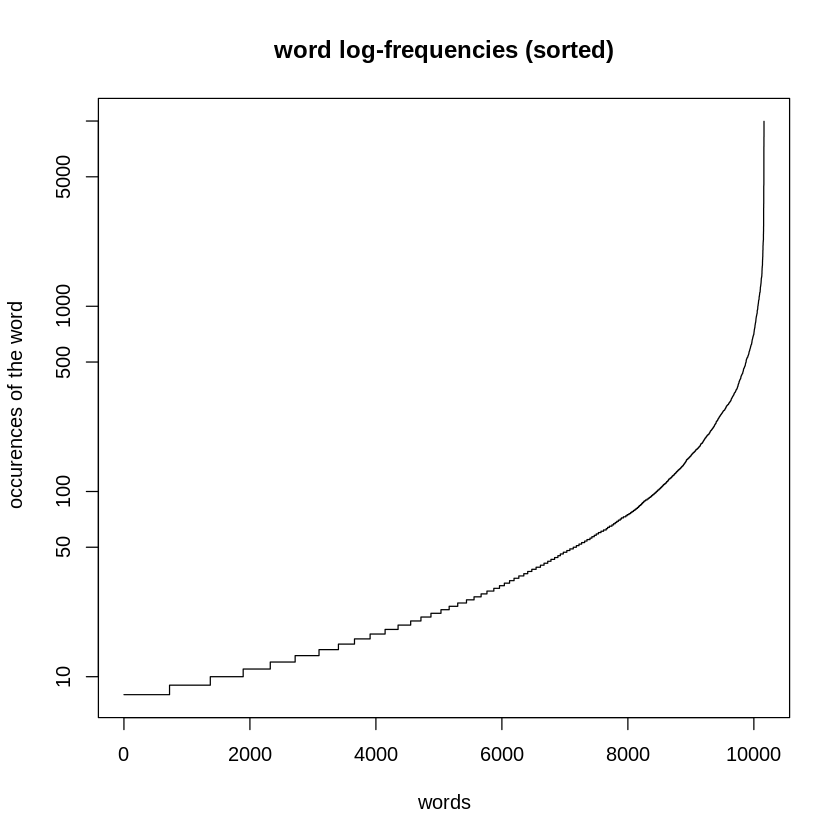

In [ ]:
dfm_news <- prepare_dfm(news$title)
x_news <- quanteda::dfm_weight(dfm_news, scheme='boolean')
y_news <- as.factor(news$topic)
plot(sort(colSums(x_news)),log='y', main = 'word log-frequencies (sorted)', type = 's', xlab = 'words', ylab = ' occurences of the word')

We can see that there are a few words that are present in more one thousand titles. 

In the following plots we show through clouds of words which are the most frequent words for each class. The higher the frequence the bigger the word.

Warning message in dfm_trim.dfm(x, min_termfreq = min_count):
“dfm has been previously weighted”


[1] "TECHNOLOGY"


Warning message in dfm_trim.dfm(x, min_termfreq = min_count):
“dfm has been previously weighted”


[1] "BUSINESS"


Warning message in dfm_trim.dfm(x, min_termfreq = min_count):
“dfm has been previously weighted”


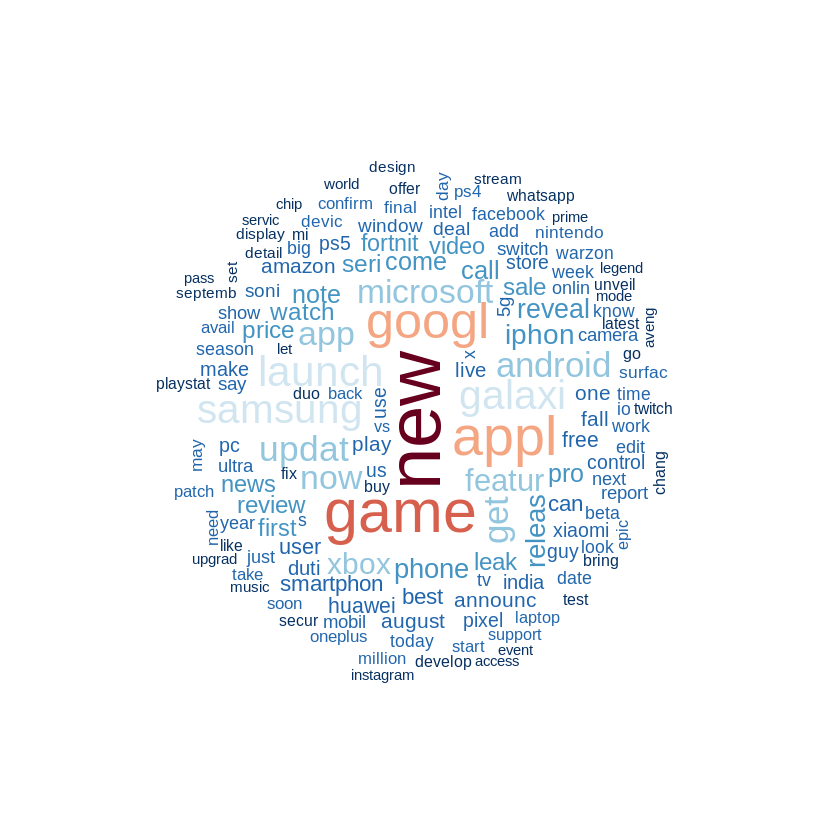

[1] "WORLD"


Warning message in dfm_trim.dfm(x, min_termfreq = min_count):
“dfm has been previously weighted”


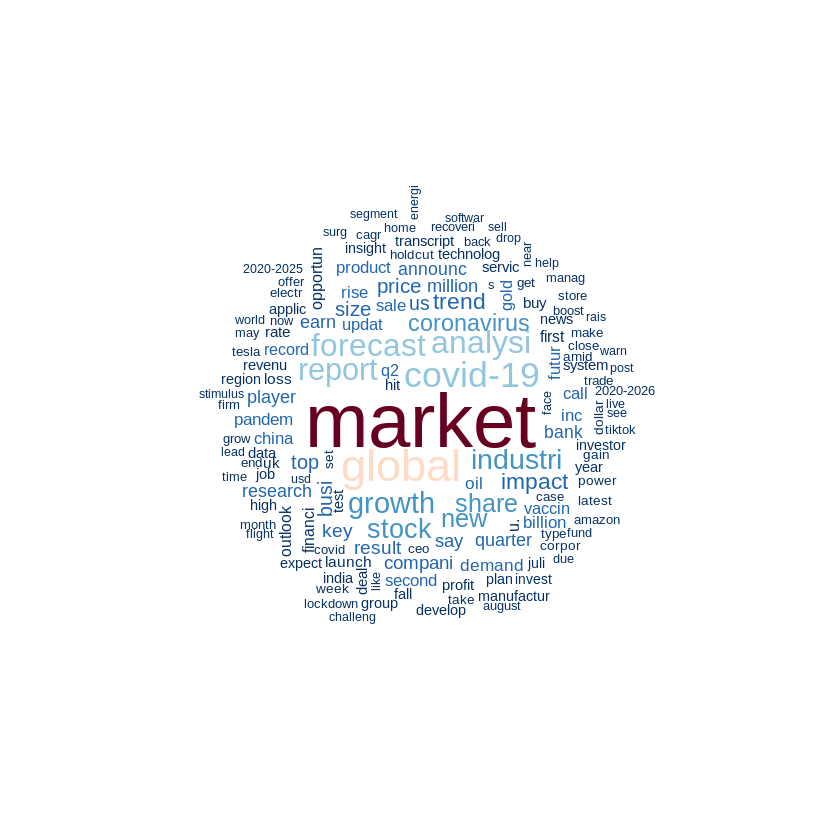

[1] "SCIENCE"


Warning message in dfm_trim.dfm(x, min_termfreq = min_count):
“dfm has been previously weighted”


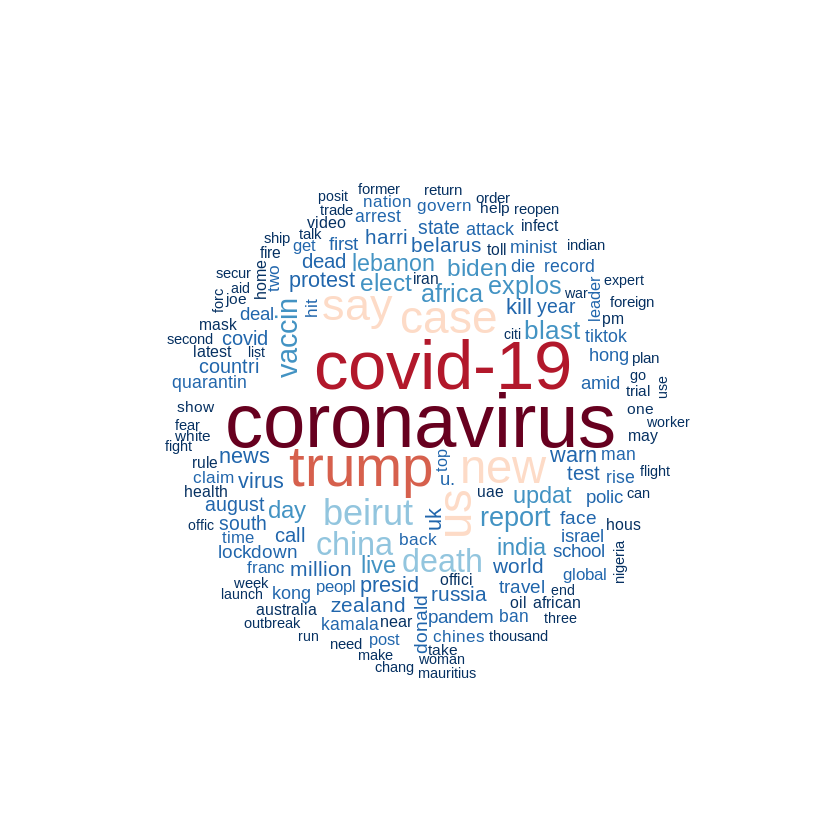

[1] "HEALTH"


Warning message in dfm_trim.dfm(x, min_termfreq = min_count):
“dfm has been previously weighted”


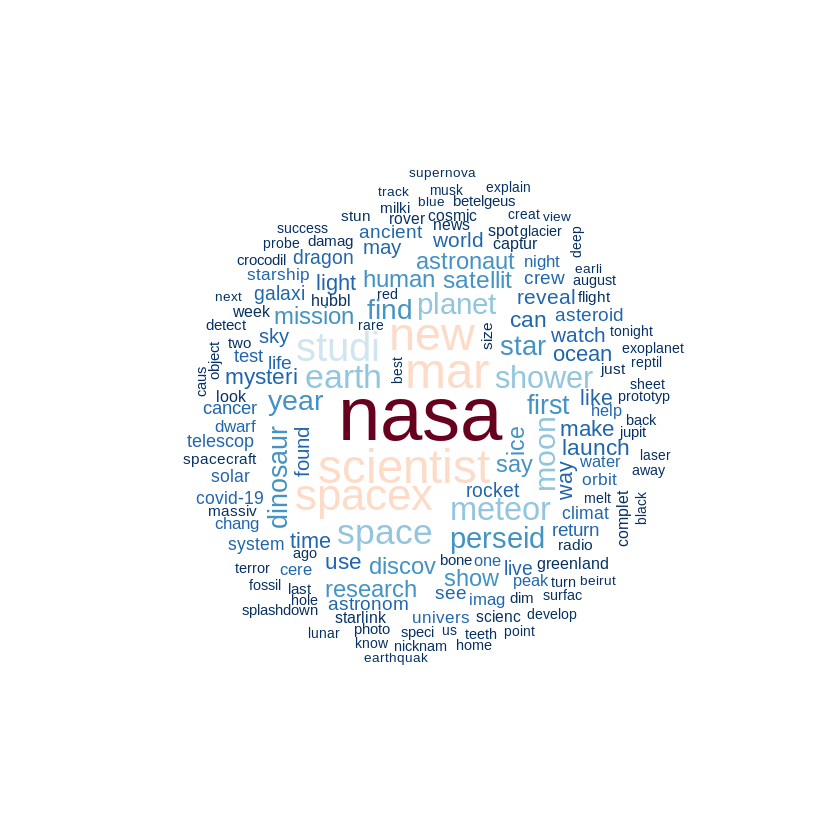

[1] "ENTERTAINMENT"


Warning message in dfm_trim.dfm(x, min_termfreq = min_count):
“dfm has been previously weighted”


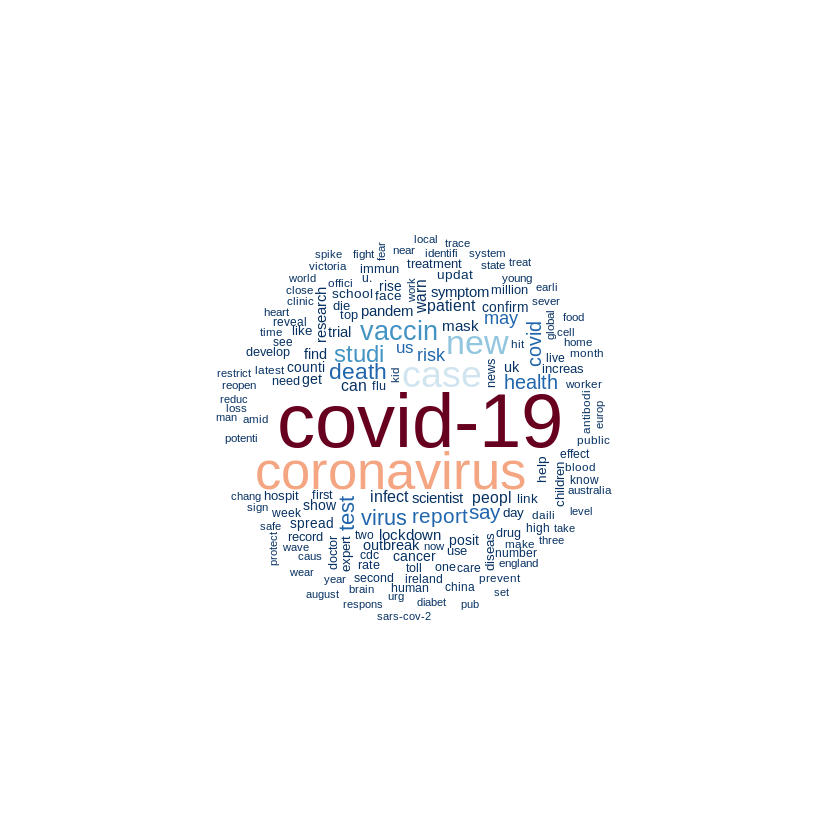

[1] "SPORTS"


Warning message in dfm_trim.dfm(x, min_termfreq = min_count):
“dfm has been previously weighted”


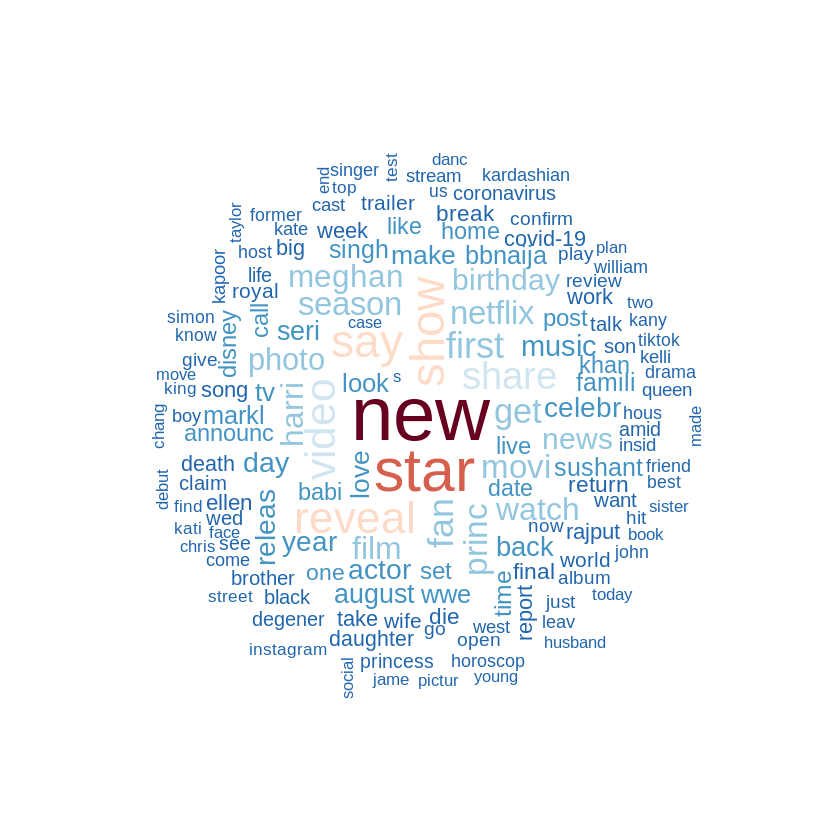

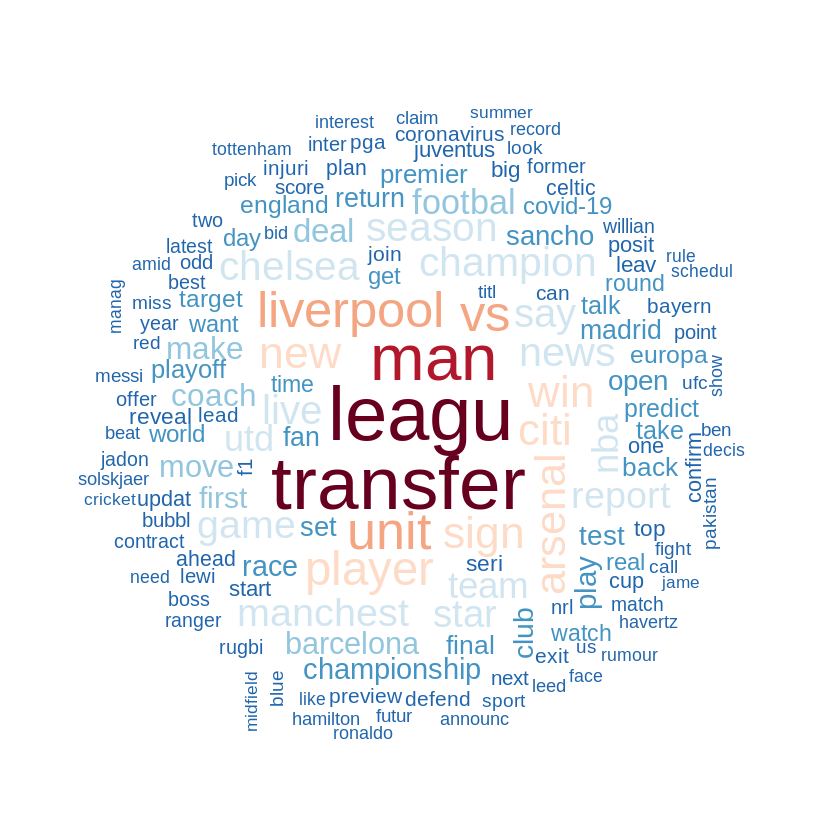

[1] "NATION"


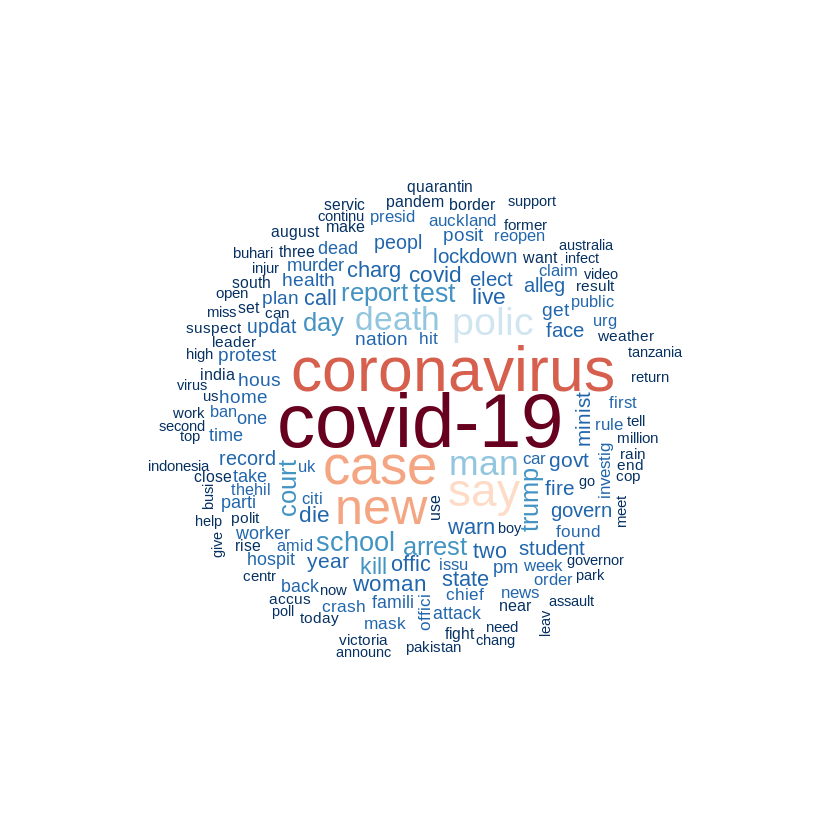

In [ ]:
par(mfrow = c(1,1))
docvars(x_news, 'topic') <- news$topic

for (i in c('TECHNOLOGY', 'BUSINESS', 'WORLD' ,'SCIENCE' ,'HEALTH', 'ENTERTAINMENT' ,'SPORTS', 'NATION')){
  topic.todisplay <- i
  textplot_wordcloud(
    dfm_subset(x_news, topic==topic.todisplay),
    color=rev(RColorBrewer::brewer.pal(10, "RdBu")),
    max_words = 150
  )
  print(i)
}

# Building Models

At this point we can start build our classifiers. Remind that having 8 classes we can consider as $1/8 = 0.125$ as baseline for our accuracy.

In [ ]:
#We remove the useless variables to free some RAM space.
rm(list=ls()[! ls() %in% c("x_train","x_test","y_train","y_test")])
gc()

used    (Mb)  gc trigger (Mb)  max used (Mb) 
Ncells 2422867 129.4  4963577   265.1  4500268 240.4
Vcells 6951868  53.1 21391212   163.3 21382094 163.2

## Multinomial Logistic Regression, cross validation for alpha and lambda

Using the glmnet package we fit a generic elastic net tunig the values of lambda and alpha.

In [ ]:
registerDoMC()

foldid <- sample(1:3, size = length(y_train), replace = TRUE)
cv1 <- cv.glmnet(x_train, y_train, family="multinomial", type.measure="class", nfolds=3, parallel=TRUE, foldid = foldid, alpha = 1)
cv.5 <- cv.glmnet(x_train, y_train, family="multinomial", type.measure="class", nfolds=3, parallel=TRUE, foldid = foldid, alpha = 0.5)
cv0 <- cv.glmnet(x_train, y_train, family="multinomial", type.measure="class", nfolds=3, parallel=TRUE, foldid = foldid, alpha = 0)
cv.8 <- cv.glmnet(x_train, y_train, family="multinomial",type.measure="class", nfolds=3, parallel=TRUE, foldid = foldid, alpha = 0.8)
cv.2 <- cv.glmnet(x_train, y_train, family="multinomial",type.measure="class", nfolds=3, parallel=TRUE, foldid = foldid, alpha = 0.2)

In [ ]:
c(min(cv0$cvm), min(cv.2$cvm), min(cv.5$cvm), min(cv.8$cvm), min(cv1$cvm))

[1] 0.2144934 0.2197681 0.2205036 0.2207679 0.2208598

We can see that the best result is achieved using ridge regression. Let's plot the results for the alpha - 1, 0.5 and 0

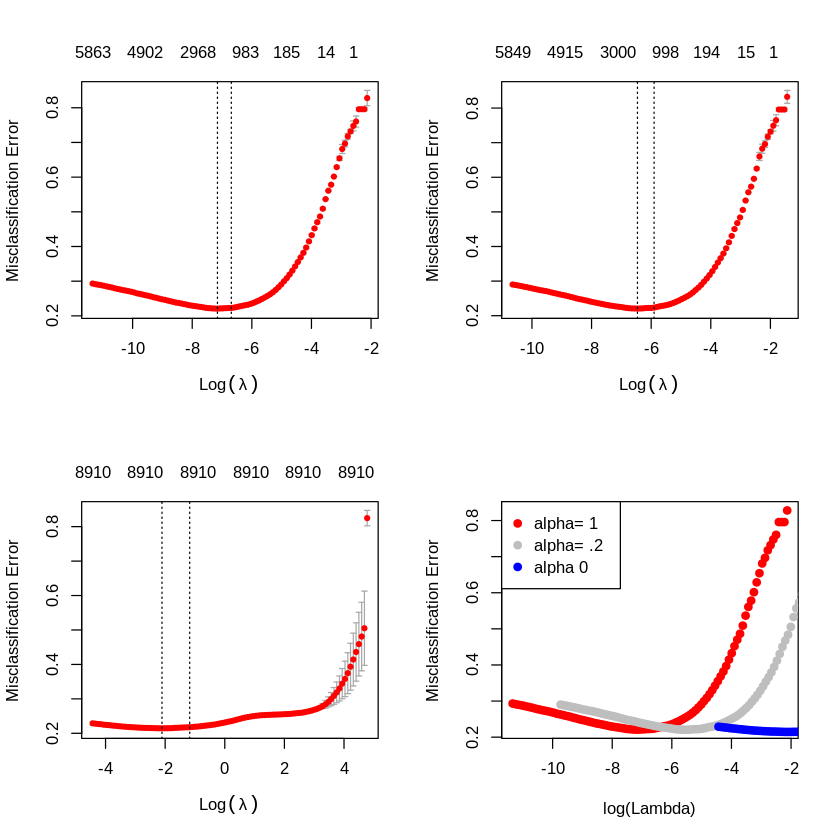

In [ ]:
par(mfrow = c(2,2))
plot(cv1); plot(cv.5); plot(cv0);
plot(log(cv1$lambda) , cv1$cvm , pch = 19, col = "red",
xlab = "log(Lambda)", ylab = cv1$name)
points(log(cv.2$lambda), cv.5$cvm, pch = 19, col = "grey")
points(log(cv0$lambda) , cv0$cvm , pch = 19, col = "blue")
legend("topleft", legend = c("alpha= 1", "alpha= .2", "alpha 0"),pch = 19, col = c("red","grey","blue"))

Let's make a prediction using the model with alpha = 0

In [ ]:
pred.train <- predict(cv0, newx = x_train, type="class")
pred.test <- predict(cv0, newx=x_test, type="class")
print(mean(y_train==pred.train))
print(mean(y_test==pred.test))

[1] 0.8280605
[1] 0.7856585


The best model gives the accuracy on the test set 79.2%

\Plot the word cloud based on the absolute value of the coefficients 

In [ ]:
# plot worldcloud with coefficients
plot_coefs <- function(coefs, features) {
	dfm.coefs <- quanteda::dfm(tokens(''))
	dfm.coefs <- dfm_match(dfm.coefs, features) + 1
	abs.coefs <- abs(as.vector(coefs)[-1])
	names(abs.coefs) <- features
	dfm.coefs <- dfm_weight(dfm.coefs, weights=abs.coefs,force=TRUE)
	textplot_wordcloud(
		dfm.coefs,
		color=rev(RColorBrewer::brewer.pal(10, "RdBu")),
    max_words = 100)
}

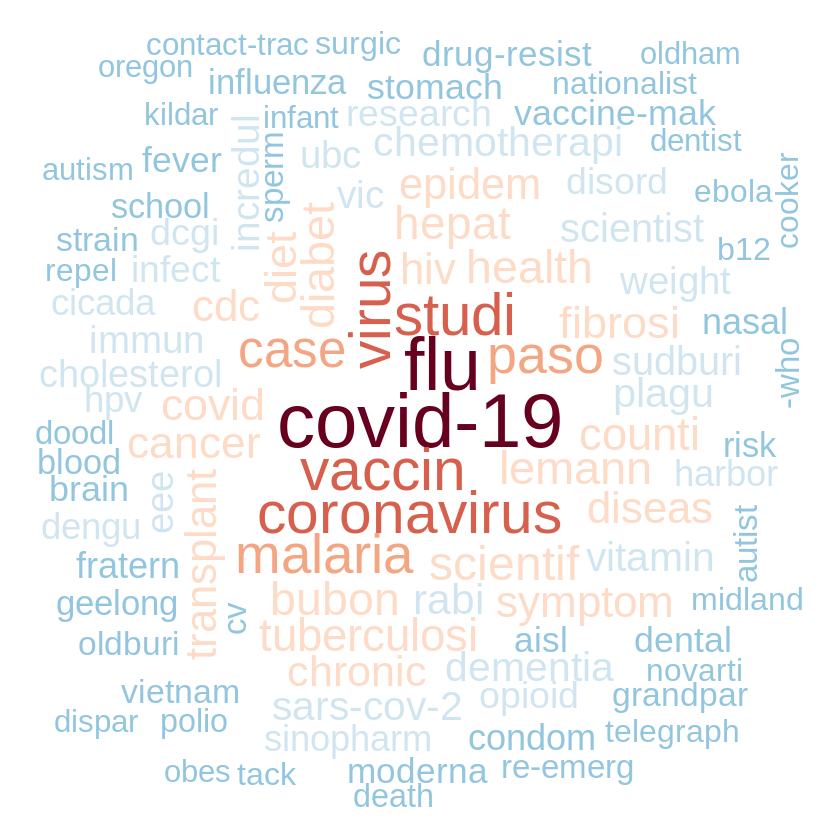

In [ ]:
plot_coefs(coef(cv1)$HEALTH, colnames(x_train))

## Sparse SVM

Now we try to implement a sparse SVM with lasso penalty. We know by the theory that the results should be similar to logistic lasso.

Unforntunately for this model the RAM size is a severe bottle neck and thus we can use only a fraction $\rho$ of the original dataset as training set.
Moreover the package sparseSVM can implement only binary classification so we need to implement a one-vs-rest approach in a for loop.

First of all we implement a cross validation for few categories to have an idea of the range values for lambda. Then, with these lambdas we implement the loop.

In [ ]:
#dataset reduction
set.seed(123)
rho = 0.1
size <- floor(rho * nrow(x_train))
mask <- sample(seq_len(nrow(x_train)), size=size)
x_train_small <- x_train[mask, ]
y_train_svm <- y_train[mask]

#for parallel computing we need a matrix
x_train_svm <- as.matrix(x_train_small)


Start parallel computing for cross-validation...

[1] 0.01570966

Start parallel computing for cross-validation...

[1] 0.0247093

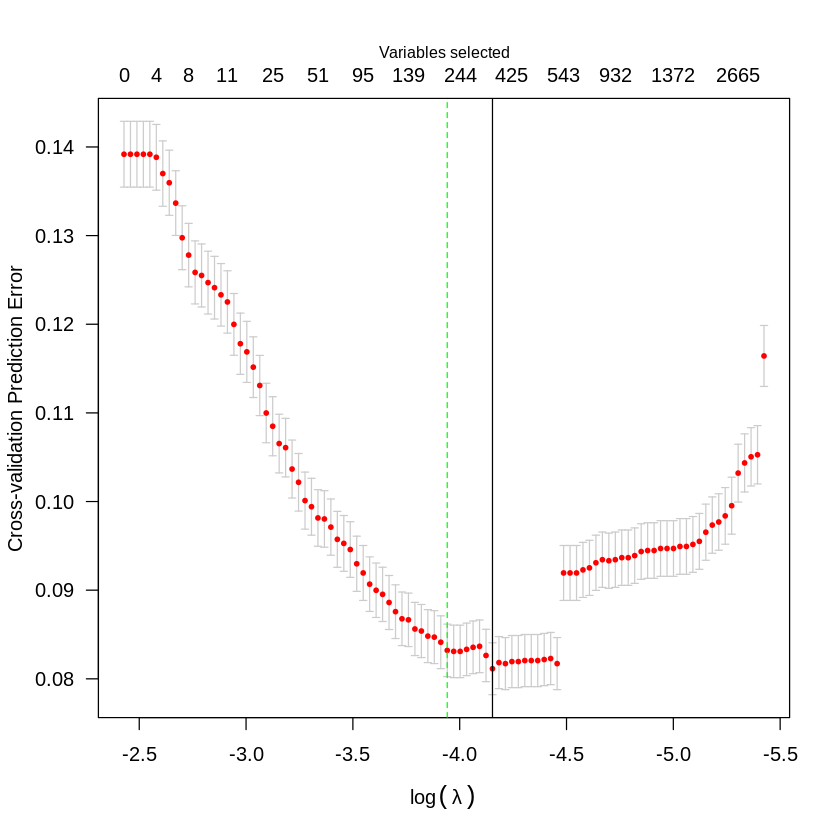

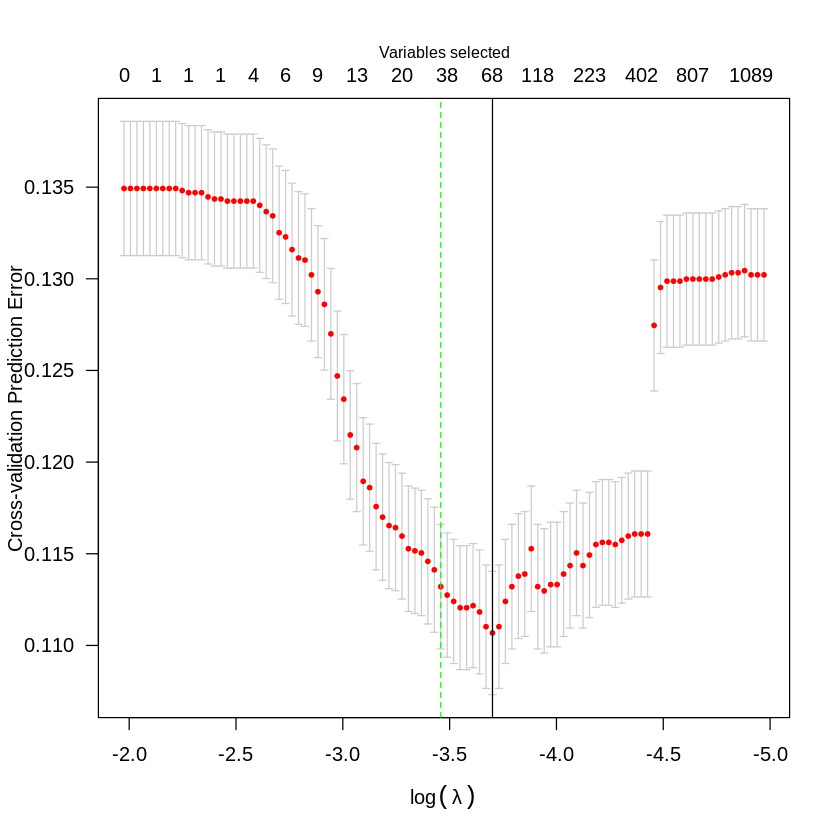

In [ ]:
tec <- c(y_train_svm=='TECHNOLOGY')+0

cv.svm <- cv.sparseSVM(x_train_svm, tec, nfolds = 6 , ncores = 2)
cv.svm$lambda.min
plot(cv.svm)
rule1se <- max(cv.svm$lambda[cv.svm$cve <= min(cv.svm$cve)+cv.svm$cvse[cv.svm$min]])
abline(v=log(cv.svm$lambda.min))
abline(v=log(rule1se),col="green", lty=2)

busi <- c(y_train_svm=='BUSINESS')+0

cv.svm <- cv.sparseSVM(x_train_svm, busi, nfolds = 6 , ncores = 2)
cv.svm$lambda.min
plot(cv.svm)
rule1se <- max(cv.svm$lambda[cv.svm$cve <= min(cv.svm$cve)+cv.svm$cvse[cv.svm$min]])
abline(v=log(cv.svm$lambda.min))
abline(v=log(rule1se),col="green", lty=2)

# with one tenth of the original training set this cell requires 6 minutes

From now on we set as grid of values for lambda 10 values. In the following for loop the predicted values are independently computed for each class. 

In [ ]:
x_test_svm <- as.matrix(x_test)

topics <- c('TECHNOLOGY', 'BUSINESS', 'WORLD' ,'SCIENCE' ,'HEALTH', 'ENTERTAINMENT' ,'SPORTS', 'NATION')
primes <- c(3,5,7,11,13,17,19,23)
i=1
acc <- c()
final_pred <- rep(1, length(y_test))
for (topic in topics){
  mask <- c(y_train_svm==topic)+0
  lasso.svm <- sparseSVM(x_train_svm, mask,nlambda = 10)
  pred_train <- predict(lasso.svm, x_train_svm, lambda=lasso.svm$lambda, type='class')
  err <- as.matrix(colSums(abs(pred_train-mask)))
  lm_index <- which.min(err)
  mask_test <- c(y_test==topic)+0
  pred_test <- predict(lasso.svm, x_test_svm, lambda=lasso.svm$lambda[lm_index], type='class')
  final_pred <- final_pred * (pred_test * (primes[i]-1)+1)
  acc[i] <- 1 - sum(abs(pred_test-mask_test))/length(y_test)
  i <- i+1
}
 
acc  #the accuracies in a one-vs-rest approach for each class seems not bad, but clearly these are unbalanced results...
#a classifier which says always "rest" is right 7/8 times (0.875) and there are values even less than this...very bad


#this cell requires 4 minutes

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.4 GiB”


[1] 0.9111469 0.8746035 0.8858194 0.9698000 0.8652724 0.8996553 0.9190991
[8] 0.8613652

In [ ]:
final_pred[30:40]
length(final_pred)
sum(final_pred==1) #half of the test does not belong to any class according to these classifiers 
sum(final_pred == 15 | final_pred==21 | final_pred>23) # 1641 have more than 1 class

[1] 55  3  1 95  3 11 57 57  1  3  3

[1] 21755

[1] 10011

[1] 1641

In conclusion we can say that a Sparse SVM model is not suitable given our task and our limited computational resources, but in any case try to balance the classes with a more sistematic approach.

### OneVsRest approach with SparseSVM

In [ ]:
# make a validadtion set
size <- floor(0.6 * nrow(x_train))
mask <- sample(seq_len(nrow(x_train)), size=size)
x_val <- x_train[-mask,]
x_train <- x_train[mask, ]
y_val <- y_train[-mask]
y_train <- y_train[mask]

In [ ]:
# the function to create balanced dataset for each topic
stratify_dataset <- function(x, y, topic){
    ind_pos <- which(y==topic)
    n <- length(ind_pos)
    mask_pos <- sample(ind_pos, size=n)
    x_pos <- x[mask_pos,]
    y_pos <- rep(1, n)
    
    ind_rest <- which(y!=topic)
    mask_neg <- sample(ind_rest, size=n)
    x_neg <- x_train[mask_neg,]
    y_neg <- rep(0, n)
    
    x_svm <- rbind(x_pos, x_neg)
    y_svm <- c(y_pos, y_neg)
    res <- list(x_svm, y_svm)
    return (res)
}

In [ ]:
# training procedure for sparseSVM, the best lambda is chosen using the validation set
topics <- unique(y_train)
ovr.models <- vector('list', length(topics))
ovr.acc <- vector('list', length(topics))
best.lm <- vector('list', length(topics))

for(i in 1:length(topics)) {
 #stratify for one v. rest
 topic <- topics[i]
 res_train <- stratify_dataset(x_train, y_train, topic)
 x_train_svm <- res_train[[1]]
 y_train_svm <- res_train[[2]]

 res_val <- stratify_dataset(x_val, y_val, topic)
 x_val_svm <- res_val[[1]]
 y_val_svm <- res_val[[2]]
 
 message(sprintf("\nStarted training on %s", topic))
 model.svm <- sparseSVM(as.matrix(x_train_svm), y_train_svm, nlambda = 7, lambda = c(0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 1/dim(x_train_svm)[1]))
 ovr.models[[i]] <- model.svm

 # check the best lambda on validation
 pred_val <- predict(model.svm, as.matrix(x_val_svm), lambda=model.svm$lambda, type='class')
 err <- as.matrix(colSums(abs(pred_val-y_val_svm)))
 lm_index <- which.min(err)
 best.lm[[i]] <- 1

 rm(x_train_svm)
 gc()
}

In [ ]:
# the function to make predictions using the coefficients
predict_with_coef <- function(object, lambda_index, x_test) {
  class = predict(object, x_test, lambda=object$lambda[lambda_index], type='class')
  coefs = predict(object, x_test, lambda=object$lambda[lambda_index], type='coefficients')
  coefs <- as.matrix(coefs)
  # add an interesept to the matrix
  x_test_int <- cbind(matrix(1, nrow(x_test), 1), x_test)
  preds <- x_test_int %*% coefs
  # make sure that the positive class is > 0, negative class is < 0
  if (((preds[1] <= 0) & (class[1]==0)) | ((preds[1] > 0) & (class[1]==1))){
    }  else{
      preds = -preds
    }

  return(preds)
}

In [ ]:
# make predictions over all classes by choosing the highest value 
df = data.frame(matrix(nrow = dim(x_test)[1], ncol = length(topics)))
colnames(df) <- topics

for (i in 1:length(topics)) {
  topic <- topics[i]
  model <- ovr.models[[i]]
  lm.index <- best.lm[[i]]

  # making predictions with the best lambda
  preds <- predict_with_coef(model, lm.index, x_test)
  df[i] <- as.numeric(preds)
}

predictions <- as.factor(colnames(df)[apply(df,1,which.max)])
mean(y_test == predictions)

The best result achieved with this technique is the 55% accuracy on the test set using lambda = 1/n, where n is the number of observations.

## Grouped Lasso
Using the glmnet package we fit a grouped lasso with ten values of lambda and alpha equal to 1.

In [ ]:
set.seed(123)

size1 <- floor(0.8 * nrow(news))
size2 <- floor(0.6 * nrow(news))

mask1 <- sample(seq_len(nrow(news)), size=size1)
mask2 <- sample(seq_len(size1), size=size2)

data_train_1 <- news[mask1, ]
data_train<- data_train_1[mask2, ]
data_val <- data_train_1[-mask2, ]
data_test <- news[-mask1, ]

dfm_train <- prepare_dfm(data_train$title)
dfm_val <- prepare_dfm(data_val$title, fit=FALSE, words_to_include = featnames(dfm_train))
dfm_test <- prepare_dfm(data_test$title, fit=FALSE, words_to_include = featnames(dfm_train))

# tf-idf, calculated on train
# weight the matrices with tf
x_train <- quanteda::dfm_weight(dfm_train, scheme='prop')
x_val <- quanteda::dfm_weight(dfm_val, scheme='prop')
x_test <- quanteda::dfm_weight(dfm_test, scheme='prop')
# calculate idfs on train
idfs <- docfreq(dfm_train, scheme='inverse')
# weight by idfs
x_train <- quanteda::dfm_weight(x_train, weights=idfs, force=TRUE)
x_val <- quanteda::dfm_weight(x_val, weights=idfs, force=TRUE)

x_test <- quanteda::dfm_weight(x_test, weights=idfs, force=TRUE)


y_train_1 <- as.factor(news$topic)[mask1]
y_train<-y_train_1[mask2]
y_val <- y_train_1[-mask2]
y_test <- as.factor(news$topic)[-mask1]

In [ ]:
registerDoParallel()
cv <- glmnet(x_train, y_train, family="multinomial", type.measure="class",nlambda = 10, parallel=TRUE,type.multinomial='grouped')

In [ ]:
cv$lambda

[1] 1.345657e-01 4.836040e-02 1.737983e-02 6.245986e-03 2.244691e-03
 [6] 8.067001e-04 2.899130e-04 1.041893e-04 3.744370e-05 1.345657e-05

Let's make a prediction using the model

In [ ]:
pred.train <- predict(cv, newx = x_train, type="class")
pred.val <- predict(cv, newx=x_val, type="class")

In [ ]:
for (x in c('s0','s1','s2','s3','s4','s5','s6','s7','s8','s9')) {
  print(x)
  print('test acc:')
  print(mean(y_train==pred.train[,x]))
  print('val acc:')
  print(mean(y_val==pred.val[,x]))
}

[1] "s0"
[1] "test acc:"
[1] 0.139403
[1] "val acc:"
[1] 0.1360147
[1] "s1"
[1] "test acc:"
[1] 0.3676299
[1] "val acc:"
[1] 0.3650655
[1] "s2"
[1] "test acc:"
[1] 0.6179823
[1] "val acc:"
[1] 0.6078603
[1] "s3"
[1] "test acc:"
[1] 0.7620434
[1] "val acc:"
[1] 0.7366123
[1] "s4"
[1] "test acc:"
[1] 0.8407085
[1] "val acc:"
[1] 0.7791312
[1] "s5"
[1] "test acc:"
[1] 0.884316
[1] "val acc:"
[1] 0.7751322
[1] "s6"
[1] "test acc:"
[1] 0.9089084
[1] "val acc:"
[1] 0.7569294
[1] "s7"
[1] "test acc:"
[1] 0.9207067
[1] "val acc:"
[1] 0.7401057
[1] "s8"
[1] "test acc:"
[1] 0.9207526
[1] "val acc:"
[1] 0.7400598
[1] "s9"
[1] "test acc:"
[1] 0.927709
[1] "val acc:"
[1] 0.7220409


In [ ]:
pred.test <- predict(cv, newx=x_test, type="class")
print('test acc:')
print(mean(y_test==pred.test[,'s4']))

[1] "test acc:"
[1] 0.77812


The best model gives the accuracy on the test set 79% and 88% on train

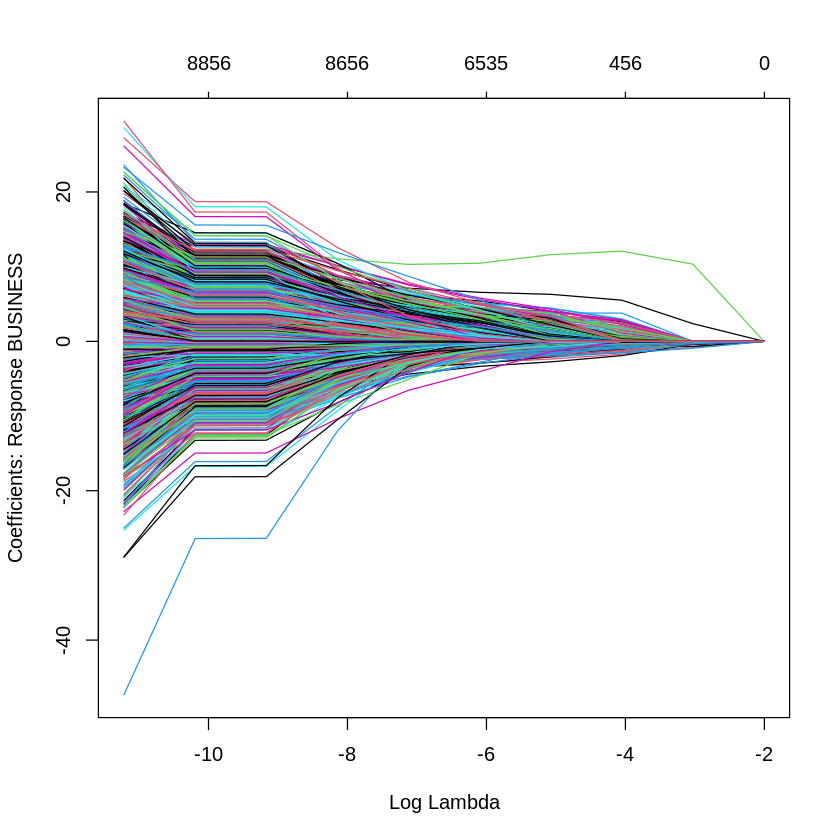

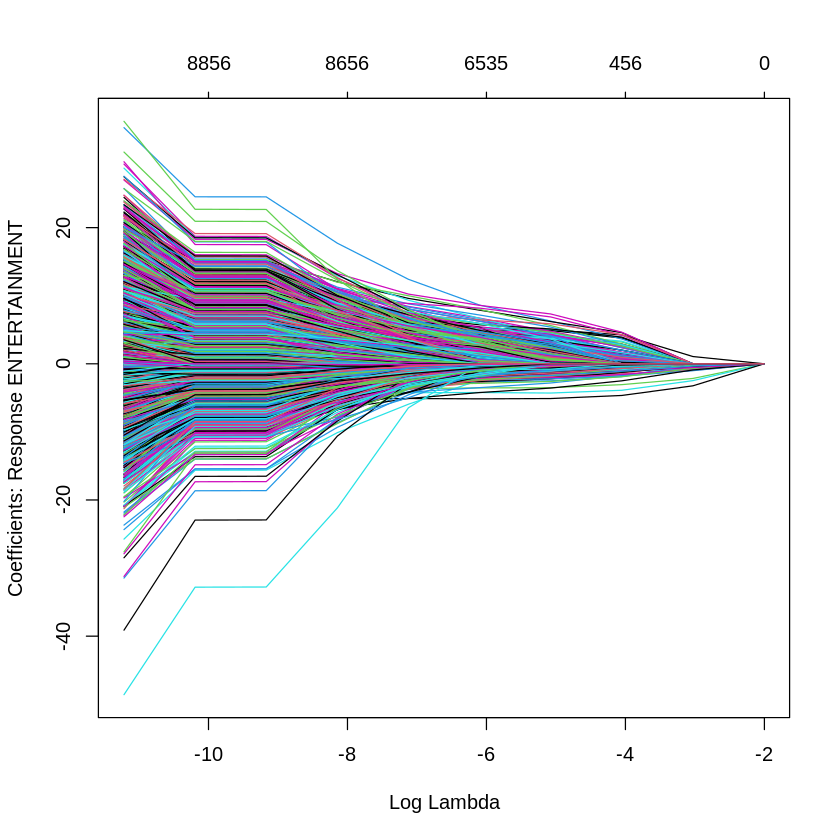

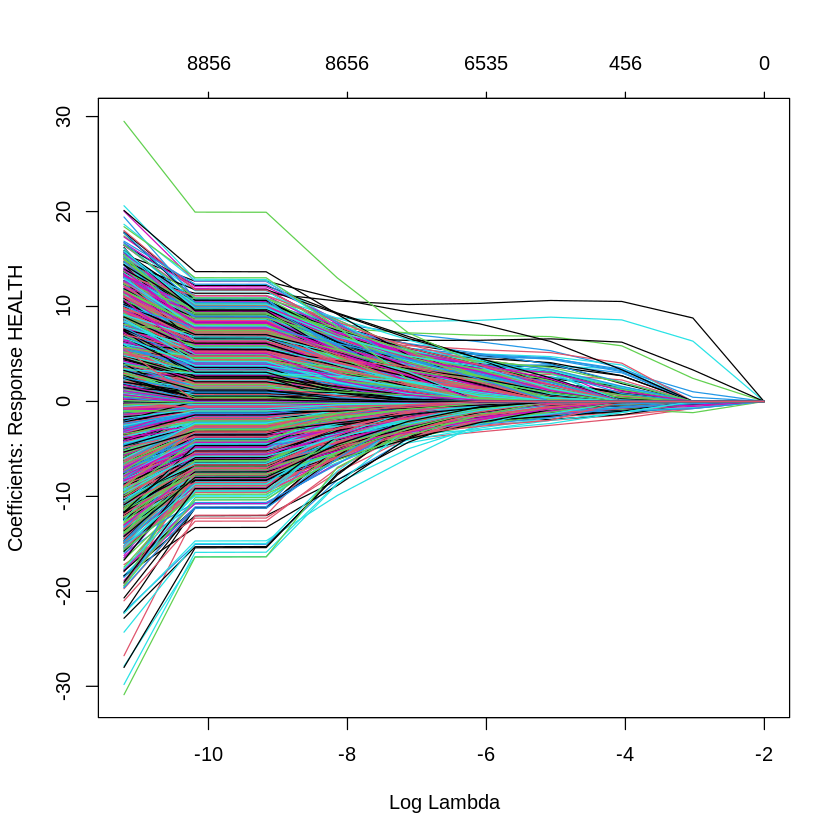

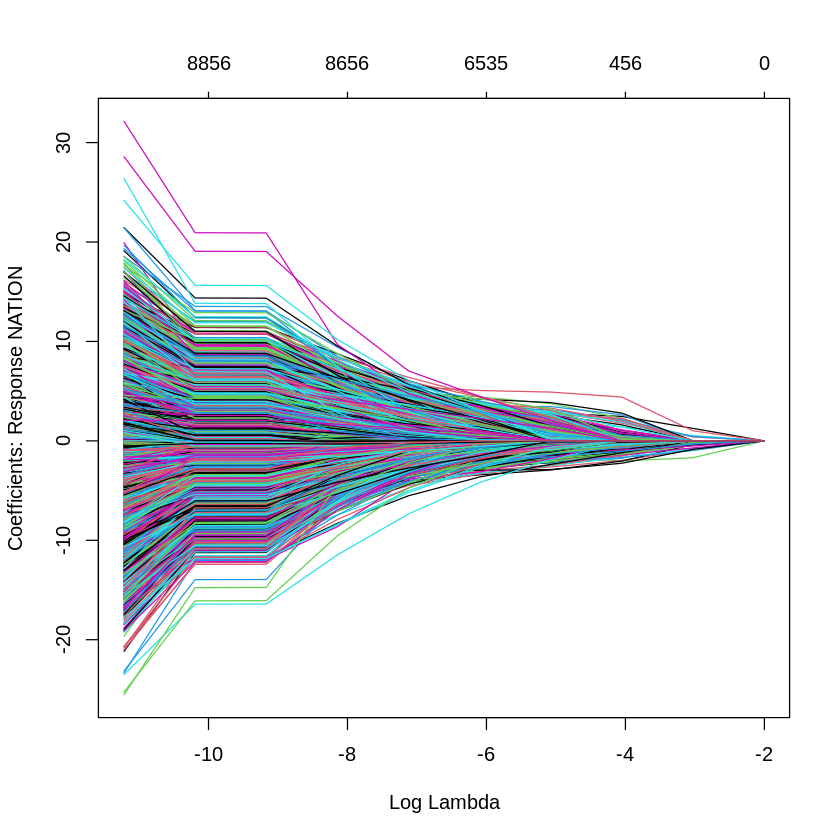

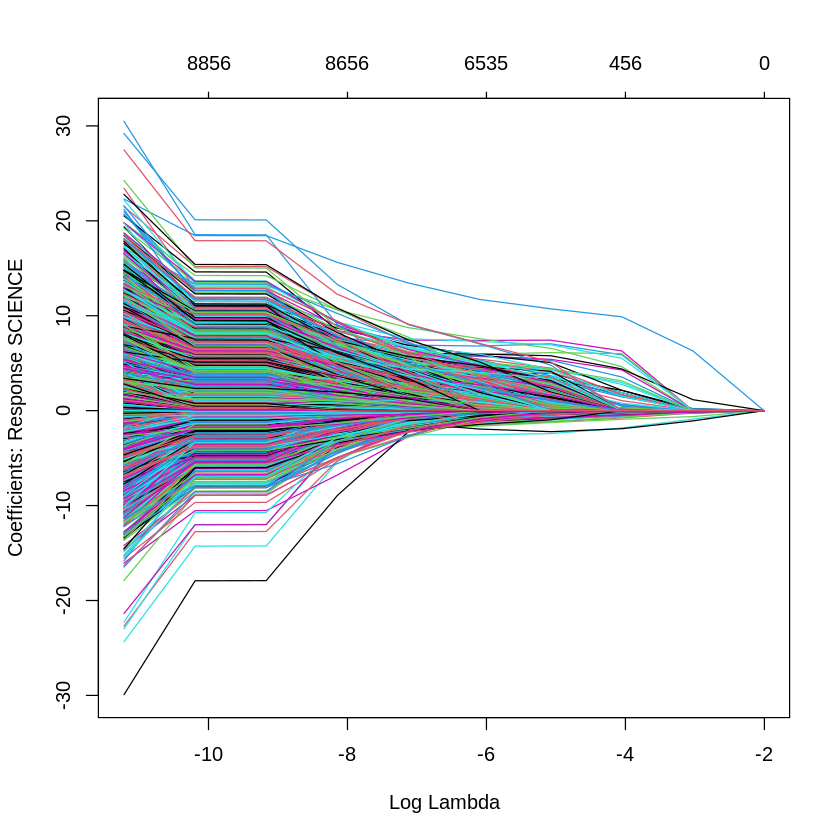

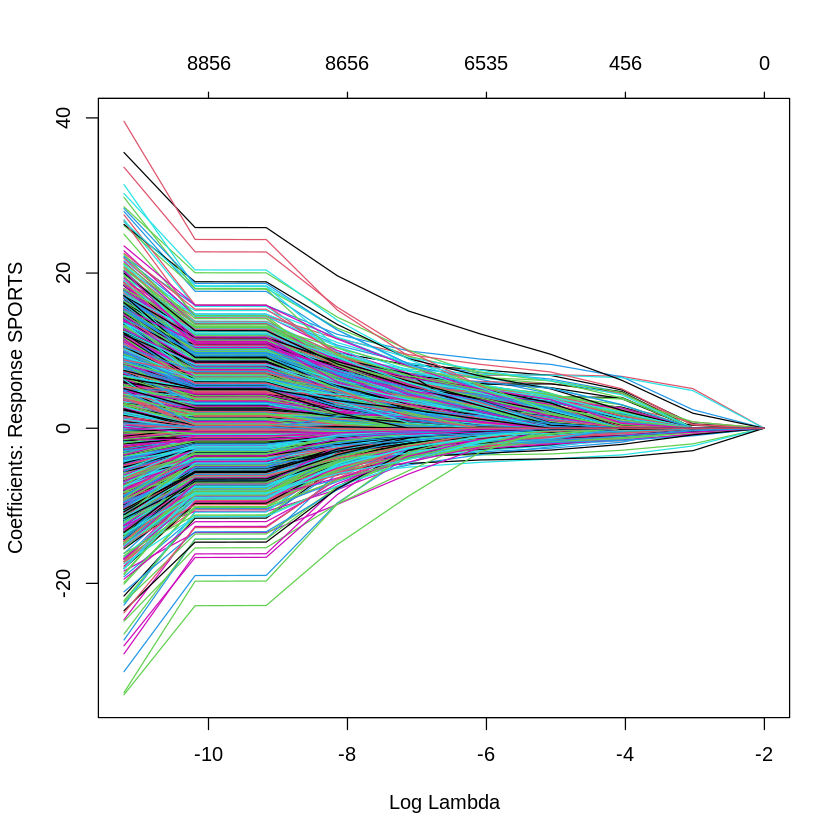

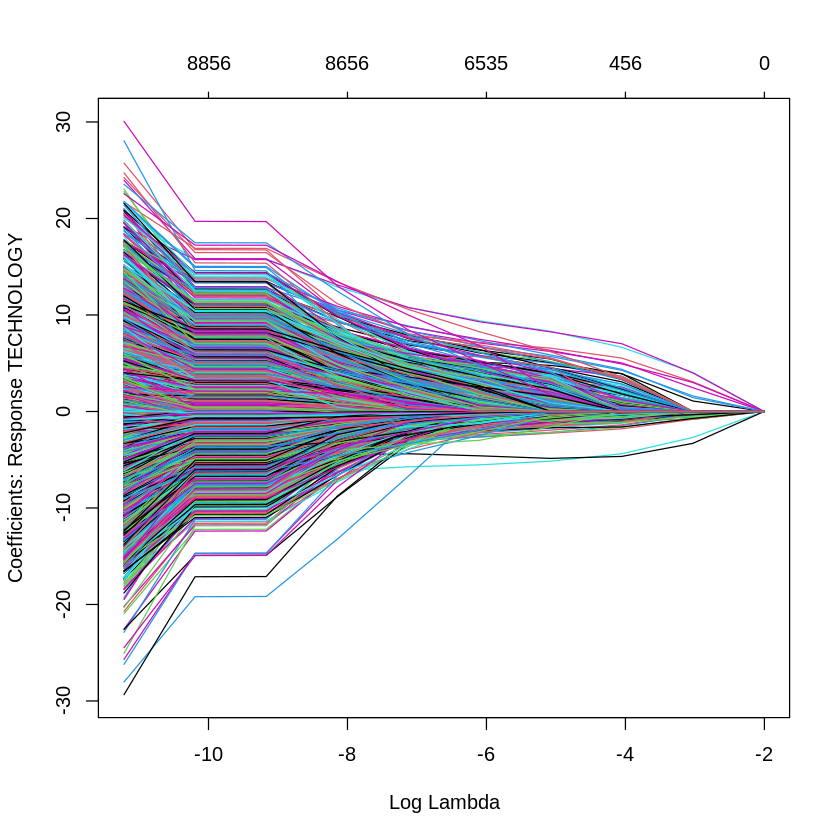

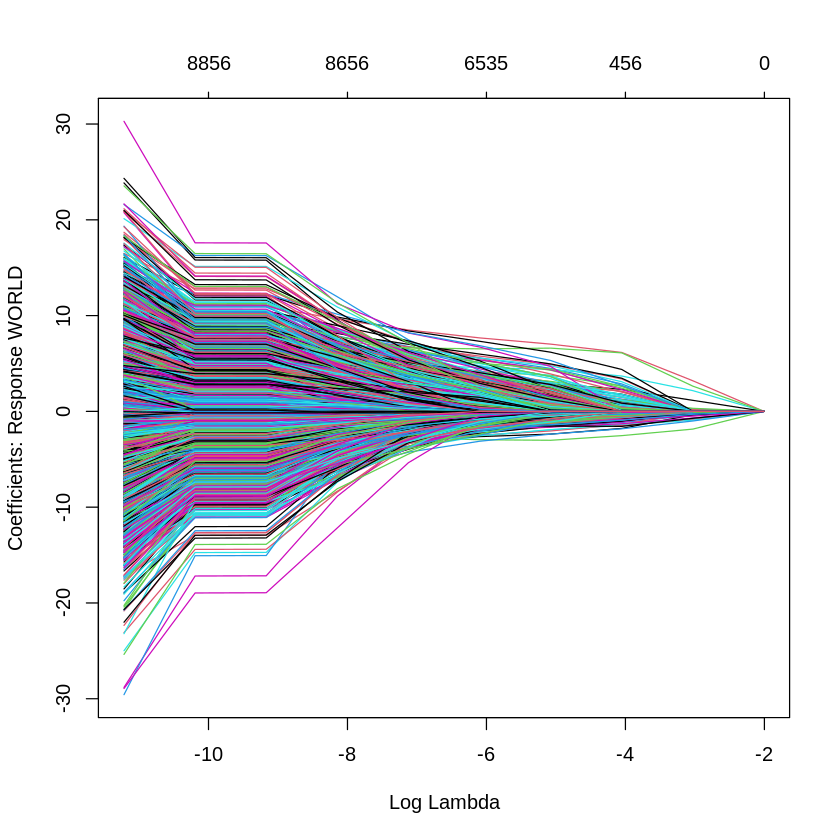

In [ ]:
plot(cv,xvar="lambda")

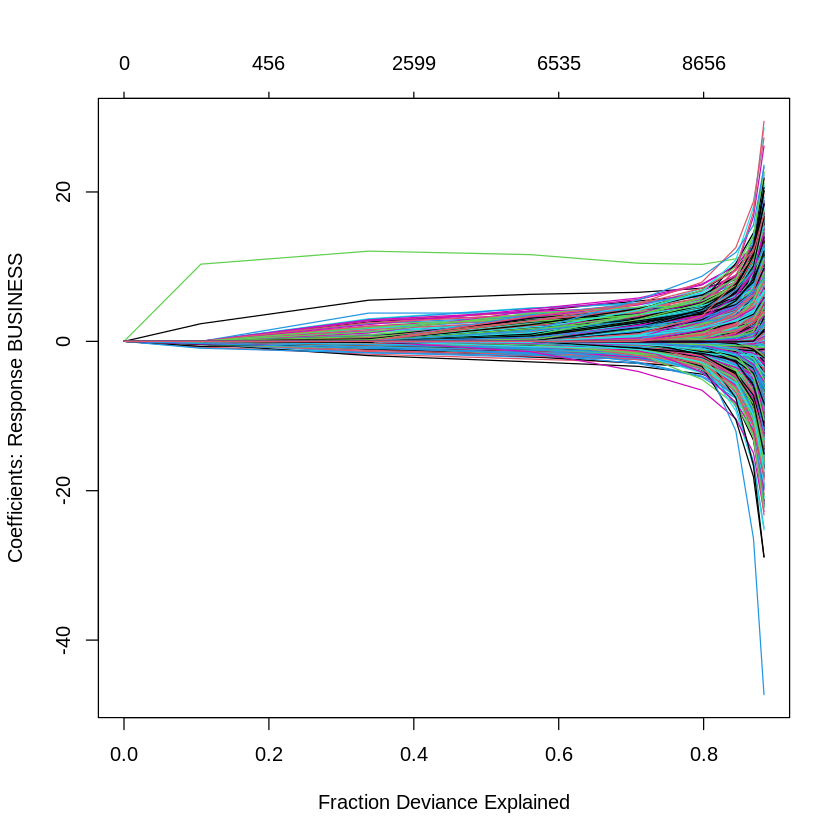

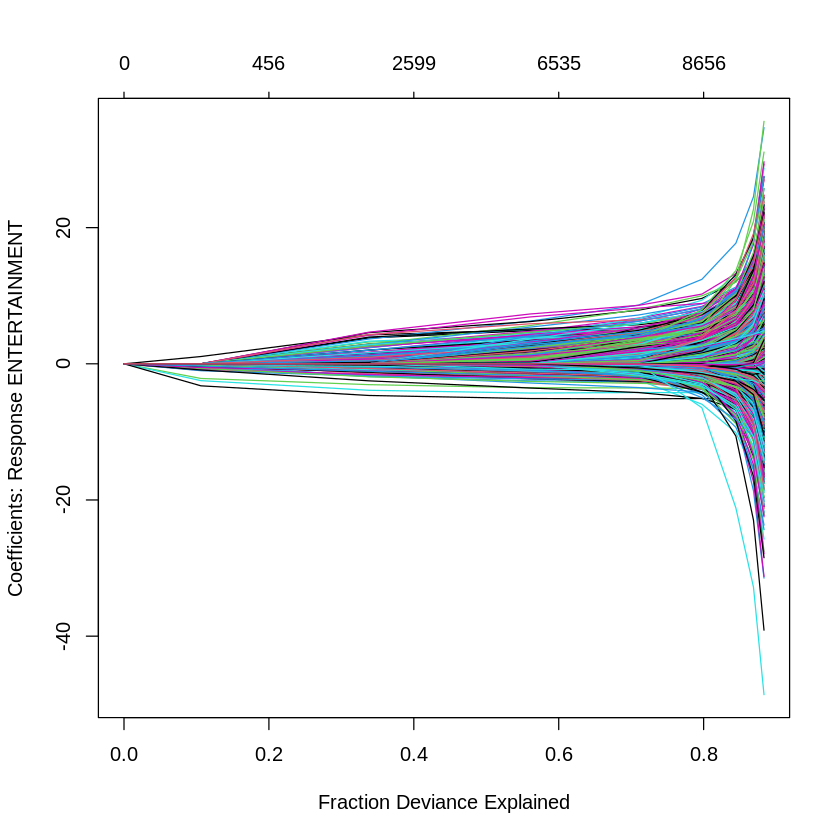

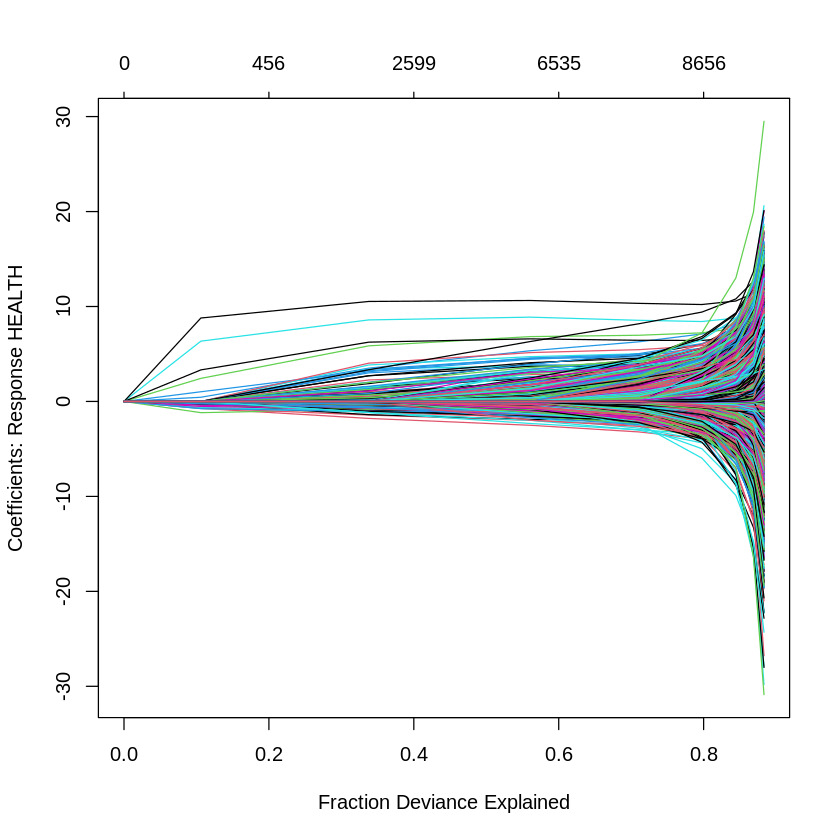

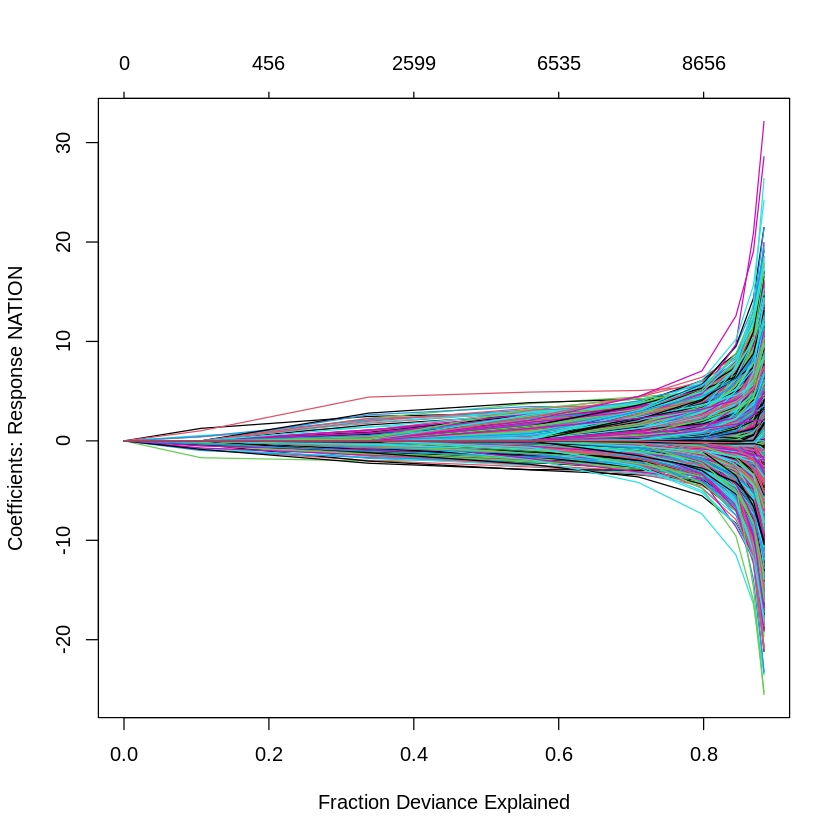

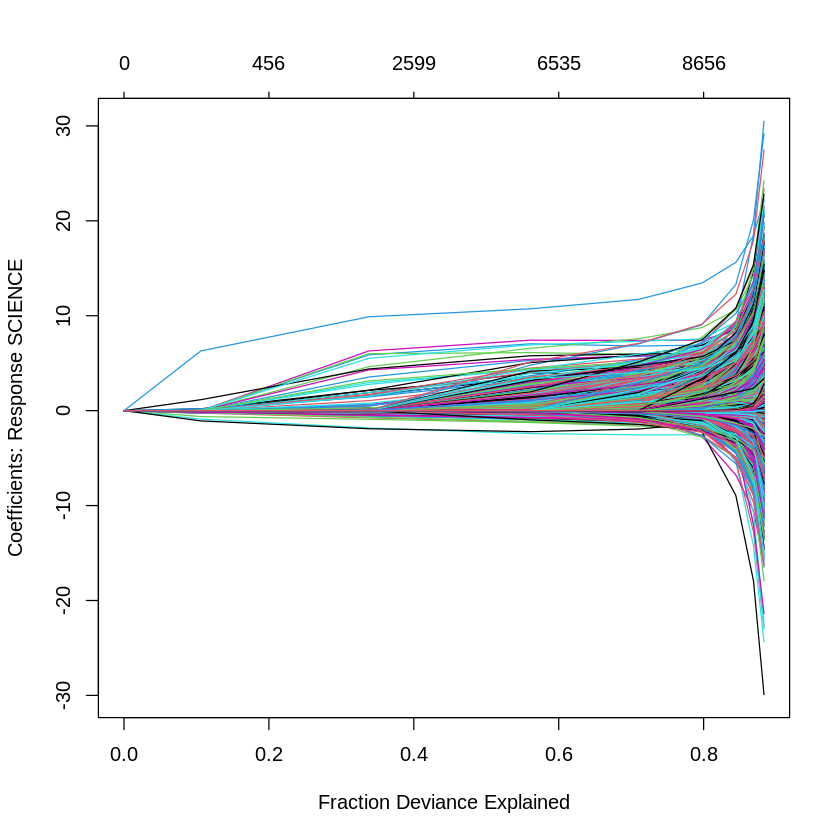

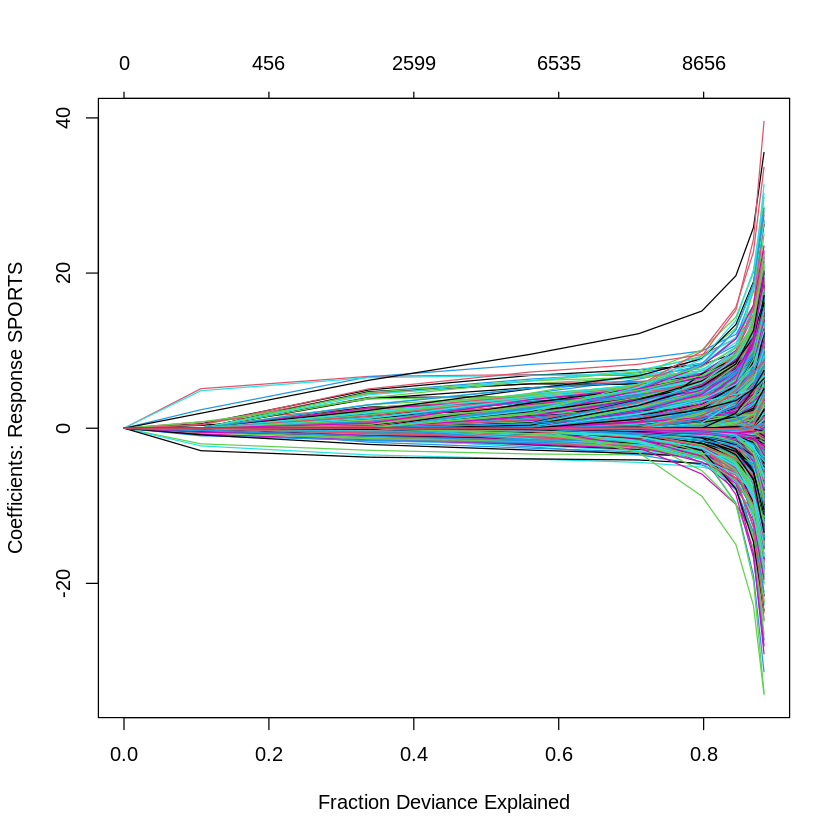

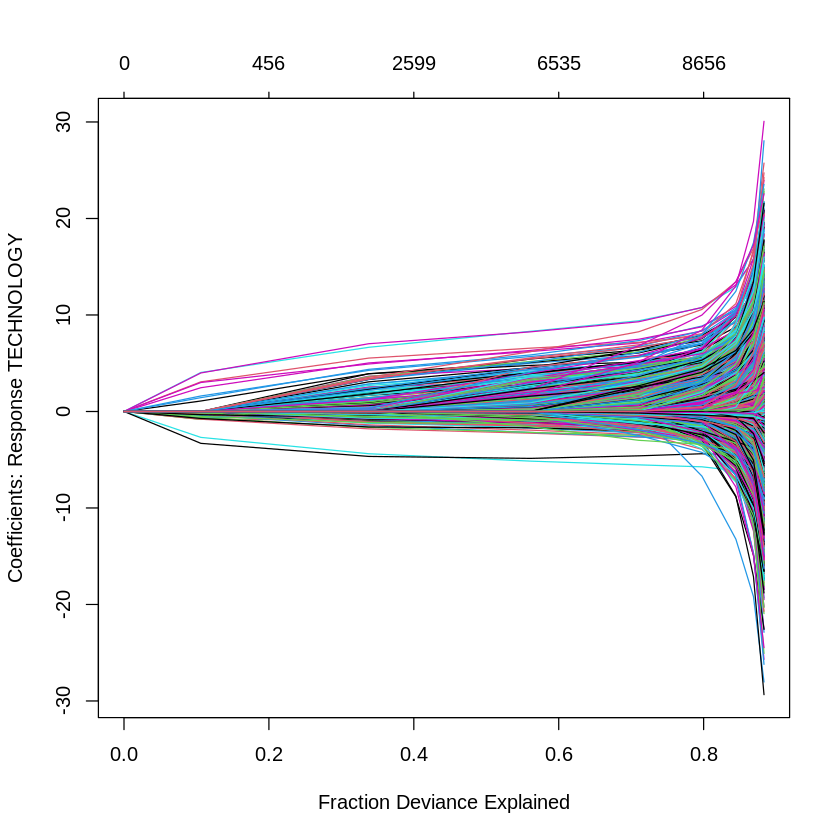

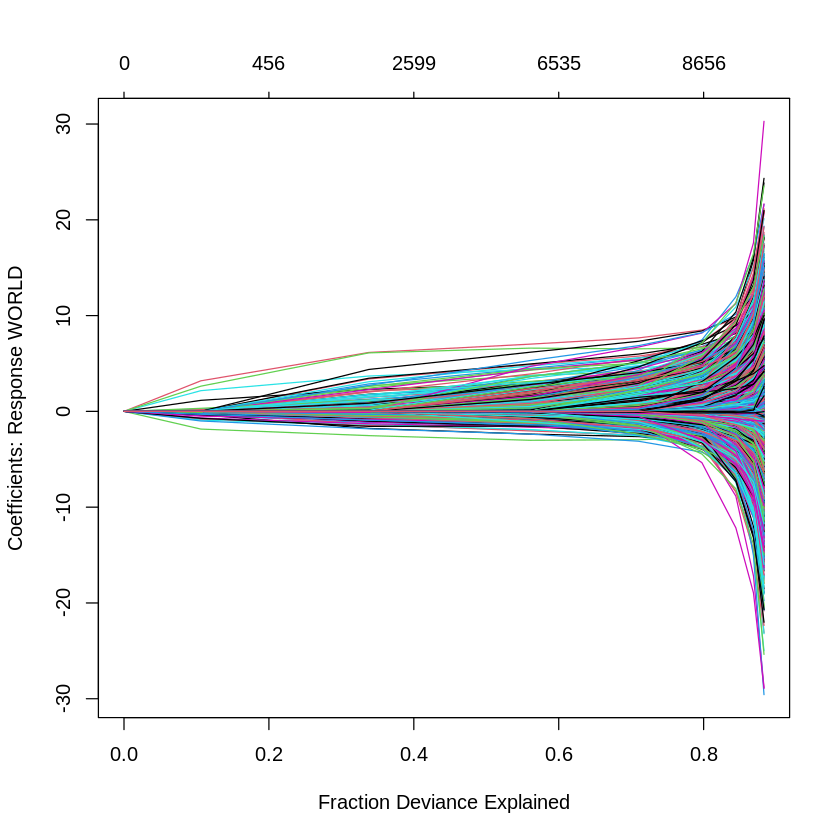

In [ ]:
plot(cv,xvar="dev")

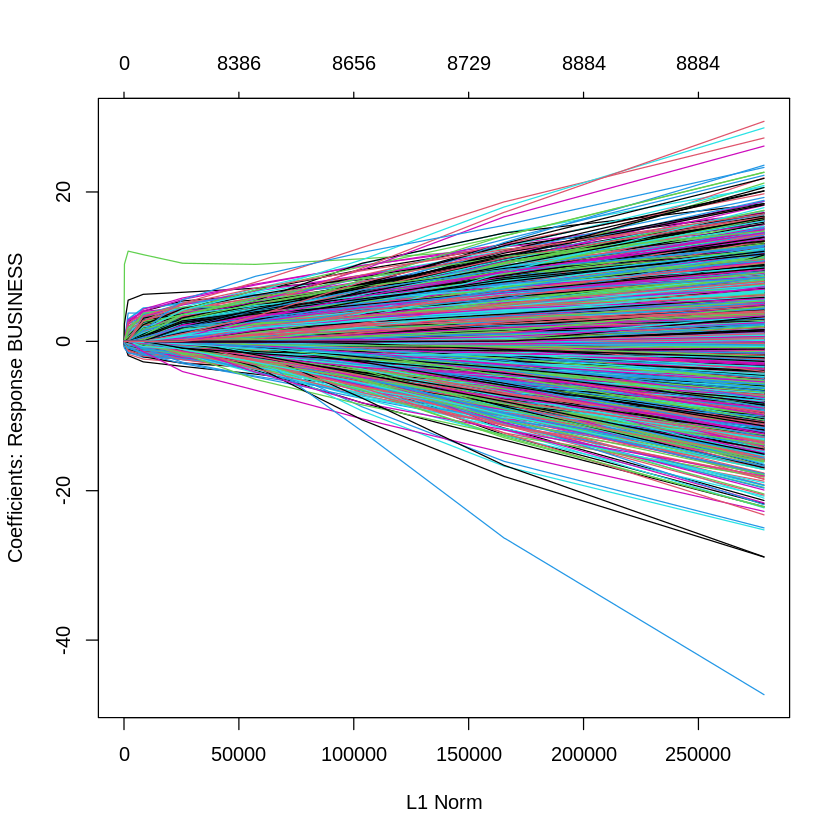

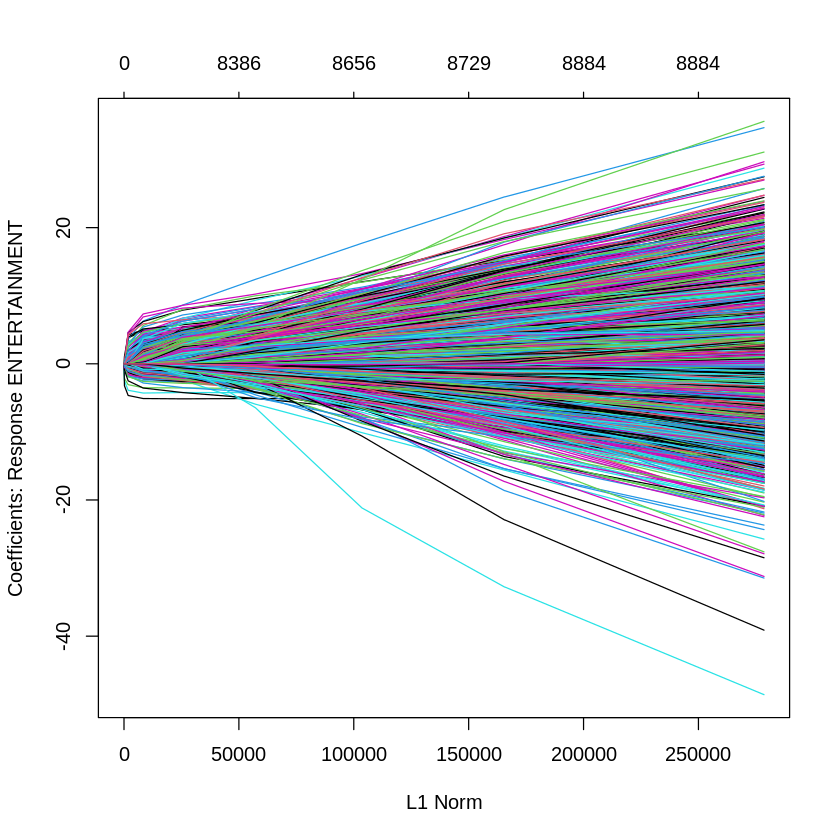

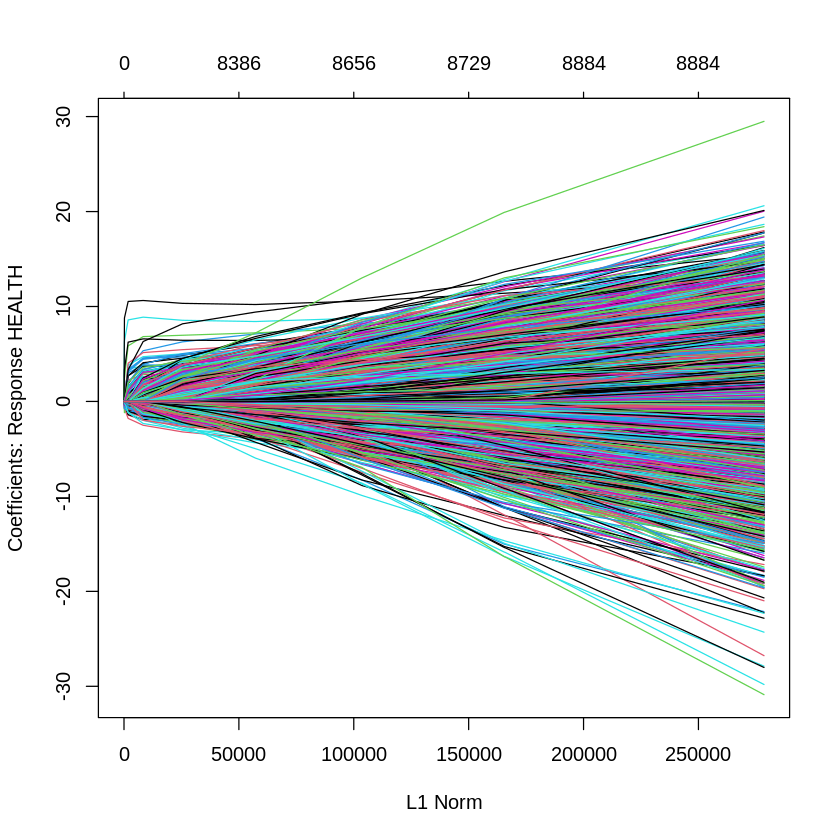

In [ ]:
plot(cv,xvar="norm")

# Word Embeddings from BERT

#### Multinomial logistic regression

In [ ]:
options(timeout=300)
id <- "1kgfBvHHJ-uWnth6GKP89m9dJhof3fMUu" # google file ID
news <- read.csv(sprintf("https://docs.google.com/uc?id=%s&export=download&confirm=t", id))
nrow(news)

In [ ]:
# some basic data exploration
class(news)
dim(news)
object.size(news)
head(news)
sum(is.na(news))
sum(apply(news, 1, anyNA)) 
sum(apply(news, 2, anyNA))
news_matrix <- as.matrix(news)
mean(news_matrix)
max(news_matrix)
min(news_matrix)

In [ ]:
set.seed(123)
size <- floor(0.8 * nrow(news))
mask <- sample(seq_len(nrow(news)), size=size)
x_train <- news[mask, ]
x_test <- news[-mask, ]
x_train <- as.matrix(x_train[,-769])
x_test <- as.matrix(x_test[,-769])

y_train <- as.factor(news$topic)[mask]
y_test <- as.factor(news$topic)[-mask]

In [ ]:
#We remove the useless variables to free some RAM space.
rm(list=ls()[! ls() %in% c("x_train","x_test","y_train","y_test")])
gc()

In [ ]:
registerDoParallel()

foldid <- sample(1:3, size = length(y_train), replace = TRUE)
cv1 <- cv.glmnet(x_train, y_train, family="multinomial", type.measure="class", nfolds=3, parallel=TRUE, foldid = foldid, alpha = 1)
cv0 <- cv.glmnet(x_train, y_train, family="multinomial", type.measure="class", nfolds=3, parallel=TRUE, foldid = foldid, alpha = 0)
cv05 <- cv.glmnet(x_train, y_train, family="multinomial", type.measure="class", parallel=TRUE, foldid = foldid, alpha = 0.5)

In [ ]:
c(min(cv0$cvm), min(cv05$cvm), min(cv1$cvm))

In [ ]:
pred.train <- predict(cv0, newx = x_train, type="class")
pred.test <- predict(cv0, newx=x_test, type="class")
print(mean(y_train==pred.train))
print(mean(y_test==pred.test))

#### Grouped Lasso

In [ ]:
options(timeout=300)
id <- "1kgfBvHHJ-uWnth6GKP89m9dJhof3fMUu" # google file ID
news <- read.csv(sprintf("https://docs.google.com/uc?id=%s&export=download&confirm=t", id))

In [ ]:
set.seed(123)

size1 <- floor(0.8 * nrow(news))
size2 <- floor(0.6 * nrow(news))

mask1 <- sample(seq_len(nrow(news)), size=size1)
mask2 <- sample(seq_len(size1), size=size2)

data_train_1 <- news[mask1, ]
data_train<- data_train_1[mask2, ]
data_val <- data_train_1[-mask2, ]
data_test <- news[-mask1, ]

In [ ]:
registerDoParallel()
cv <- glmnet(x_train, y_train, family="multinomial", type.measure="class",nlambda = 10, parallel=TRUE,type.multinomial='grouped')

In [ ]:
pred.train <- predict(cv, newx = x_train, type="class")
pred.val <- predict(cv, newx=x_val, type="class")

In [ ]:
for (x in c('s0','s1','s2','s3','s4','s5','s6','s7','s8','s9')) {
  print(x)
  print('test acc:')
  print(mean(y_train==pred.train[,x]))
  print('val acc:')
  print(mean(y_val==pred.val[,x]))
}

In [ ]:
x<-'s5'
pred.test <- predict(cv, newx=x_test, type="class")
print('test acc:')
print(mean(y_test==pred.test[,x]))

[1] "test acc:"
[1] 0.6966075
